In [1]:
import os
import random
import numpy as np
import tensorflow as tf
from tqdm import tqdm
import zipfile
from PIL import Image
from io import BytesIO
from pathlib import Path
import matplotlib.pyplot as plt
from keras import layers
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

C:\Users\elon2\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
C:\Users\elon2\AppData\Roaming\Python\Python39\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
C:\Users\elon2\AppData\Roaming\Python\Python39\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.4' currently installed).
  from pandas.core import (


In [2]:
zip_path = os.getcwd()+'\\BS-data\\BTMI.zip'
healthy_path = 'Dataset/Brain Tumor CT scan Images/Healthy'
tumor_path = 'Dataset/Brain Tumor CT scan Images/Tumor'

In [3]:
def load_class_images(zip_path, class_path, target_size=(180, 180)):
    images = []
    with zipfile.ZipFile(zip_path) as zip_ref:
        for file in zip_ref.namelist():
            if file.startswith(class_path) and file.lower().endswith(('.png', '.jpg')):
                with zip_ref.open(file) as img_file:
                    # Convert to grayscale and resize
                    img = Image.open(BytesIO(img_file.read())).convert('RGB')
                    img = img.resize(target_size)
                    images.append(img)
    return np.array(images)

In [4]:
def plot_process(history):
    accuracy = history.history["accuracy"]
    val_accuracy = history.history["val_accuracy"]
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    epochs = range(1, len(accuracy) + 1)
    plt.plot(epochs, accuracy, "bo", label="Training accuracy")
    plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
    plt.title("Training and validation accuracy")
    plt.legend()
    plt.figure()
    plt.plot(epochs, loss, "bo", label="Training loss")
    plt.plot(epochs, val_loss, "b", label="Validation loss")
    plt.title("Training and validation loss")
    plt.legend()
    plt.show()

In [5]:
# Load both classes
healthy_images = load_class_images(zip_path, healthy_path)
tumor_images = load_class_images(zip_path, tumor_path)

# Create labels
X = np.concatenate([healthy_images, tumor_images])
y = np.array([0]*len(healthy_images) + [1]*len(tumor_images))

print(f"Total images: {len(X)} (Healthy: {len(healthy_images)}, Tumor: {len(tumor_images)})")
print(f"Image shape: {X[0].shape}")

Total images: 4618 (Healthy: 2300, Tumor: 2318)
Image shape: (180, 180, 3)


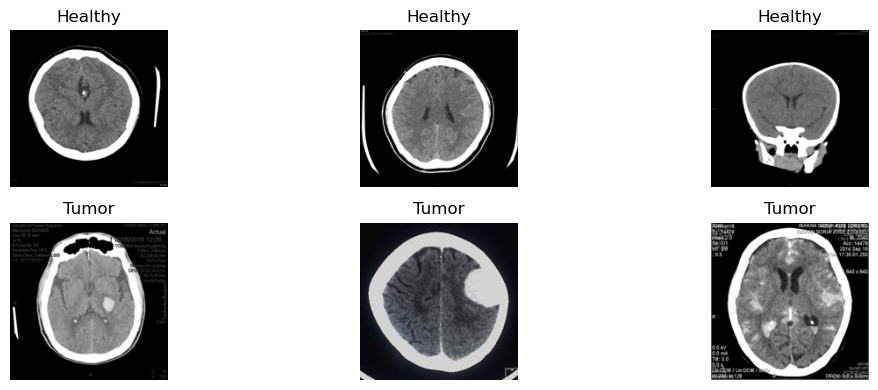

In [6]:
# Display sample images
plt.figure(figsize=(12, 4))
for i in range(3):
    plt.subplot(2, 3, i+1)
    plt.imshow(healthy_images[random.randint(0, healthy_images.shape[0]-1)], cmap='gray')
    plt.title('Healthy')
    plt.axis('off')
for i in range(3):
    plt.subplot(2, 3, i+4)
    plt.imshow(tumor_images[random.randint(0, tumor_images.shape[0]-1)], cmap='gray')
    plt.title('Tumor')
    plt.axis('off')
plt.tight_layout()
plt.show()

In [7]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=42, stratify=y_train_val)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [8]:
print(X_train.shape)
print(y_train.shape)

print(X_val.shape)
print(y_val.shape)

print(X_test.shape)
print(y_test.shape)

(2955, 180, 180, 3)
(2955,)
(739, 180, 180, 3)
(739,)
(924, 180, 180, 3)
(924,)


In [9]:
train_dataset = (X_train, y_train)
validation_dataset = (X_val, y_val)
test_dataset = (X_test, y_test)

## Model from Scratch

In [11]:
inputs = keras.Input(shape=(180, 180, 3))
x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [12]:
callbacks = [ModelCheckpoint(
        filepath= "from_scratch.keras",
        save_best_only=True,
        monitor="val_loss")]

In [13]:
print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)

(2955, 180, 180, 3) (2955,)
(739, 180, 180, 3) (739,)


In [14]:
history = model.fit(
    X_train,
    y_train,
    epochs = 30,
    validation_data = validation_dataset,
    callbacks = callbacks)

Epoch 1/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 74s 788ms/step - accuracy: 0.6751 - loss: 0.7363 - val_accuracy: 0.8606 - val_loss: 0.4085
Epoch 2/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 65s 704ms/step - accuracy: 0.8813 - loss: 0.3029 - val_accuracy: 0.8714 - val_loss: 0.2837
Epoch 3/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 66s 709ms/step - accuracy: 0.9003 - loss: 0.2349 - val_accuracy: 0.9310 - val_loss: 0.1768
Epoch 4/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 68s 733ms/step - accuracy: 0.9557 - loss: 0.1292 - val_accuracy: 0.9391 - val_loss: 0.1468
Epoch 5/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 68s 734ms/step - accuracy: 0.9598 - loss: 0.1057 - val_accuracy: 0.9445 - val_loss: 0.1396
Epoch 6/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 69s 745ms/step - accuracy: 0.9629 - loss: 0.1044 - val_accuracy: 0.9499 - val_loss: 0.1428
Epoch 7/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 73s 787ms/step - accuracy: 0.9737 - loss: 0.0697 - val_accuracy: 0.9540 - val_loss: 0.1374
Epoch 8/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 66s 711ms/step - accuracy: 0.9784 - loss: 0.0635 - val_accu

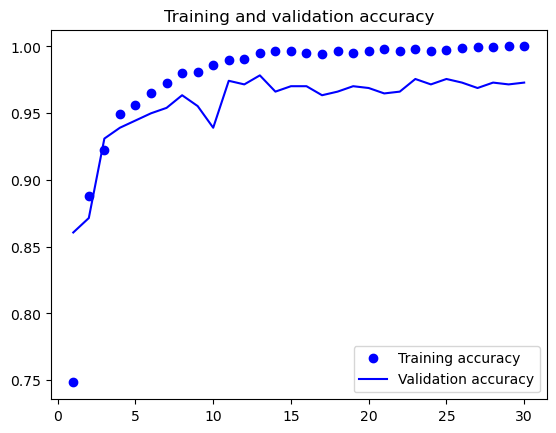

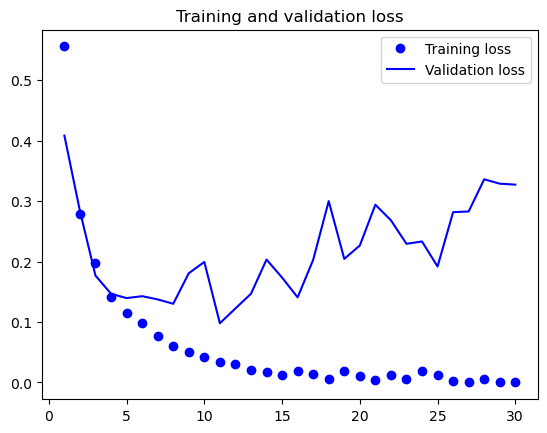

In [15]:
plot_process(history)

In [16]:
model.evaluate(X_test, y_test) 

29/29 ━━━━━━━━━━━━━━━━━━━━ 5s 179ms/step - accuracy: 0.9713 - loss: 0.4617


[0.39703577756881714, 0.9718614816665649]

In [17]:
best_model = load_model("from_scratch.keras")
best_model.evaluate(X_test, y_test)

29/29 ━━━━━━━━━━━━━━━━━━━━ 5s 173ms/step - accuracy: 0.9686 - loss: 0.1471


[0.1258920580148697, 0.9718614816665649]

## Using Data Augmentation 

In [19]:
augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
        layers.RandomBrightness(0.2)
    ]
)

<IPython.core.display.Javascript object>

In [20]:
inputs = keras.Input(shape=(180, 180, 3))
x = augmentation(inputs)
x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [21]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="from_scratch_with_augmentation.keras",
        save_best_only=True,
        monitor="val_loss")
]

<IPython.core.display.Javascript object>

In [22]:
history = model.fit(
    X_train, y_train,
    epochs=100,
    validation_data = validation_dataset,
    callbacks=callbacks)

Epoch 1/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 74s 784ms/step - accuracy: 0.6085 - loss: 0.7360 - val_accuracy: 0.8011 - val_loss: 0.4581
Epoch 2/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 82s 881ms/step - accuracy: 0.7261 - loss: 0.5636 - val_accuracy: 0.7578 - val_loss: 0.6298
Epoch 3/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 77s 815ms/step - accuracy: 0.7819 - loss: 0.4791 - val_accuracy: 0.8958 - val_loss: 0.3118
Epoch 4/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 83s 893ms/step - accuracy: 0.8297 - loss: 0.3889 - val_accuracy: 0.9107 - val_loss: 0.2716
Epoch 5/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 85s 910ms/step - accuracy: 0.8501 - loss: 0.3560 - val_accuracy: 0.8836 - val_loss: 0.2744
Epoch 6/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 76s 815ms/step - accuracy: 0.8579 - loss: 0.3318 - val_accuracy: 0.8890 - val_loss: 0.2683
Epoch 7/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 72s 772ms/step - accuracy: 0.8717 - loss: 0.3050 - val_accuracy: 0.9202 - val_loss: 0.2506
Epoch 8/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 72s 777ms/step - accuracy: 0.8914 - loss: 0.2694 - 

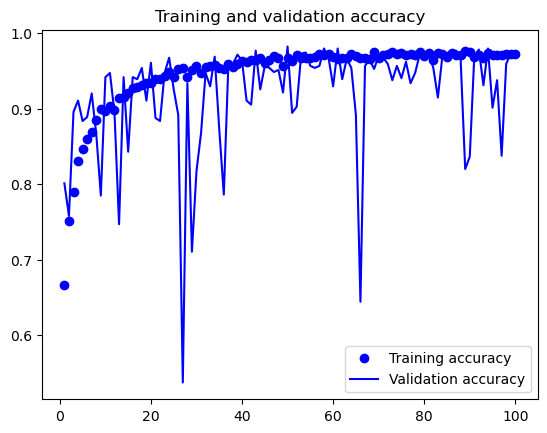

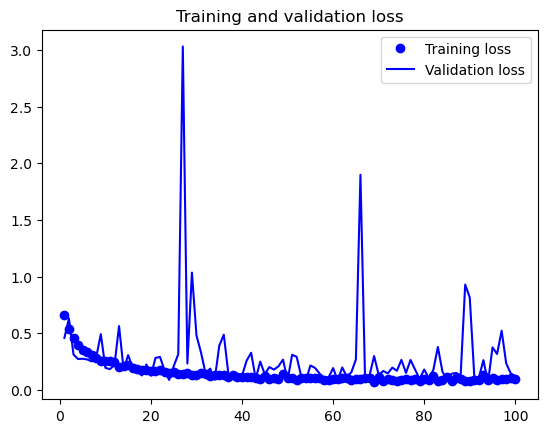

In [23]:
plot_process(history)

In [24]:
model.evaluate(X_test, y_test)

29/29 ━━━━━━━━━━━━━━━━━━━━ 5s 161ms/step - accuracy: 0.9670 - loss: 0.0995


[0.09947626292705536, 0.959956705570221]

In [25]:
best_model = load_model("from_scratch_with_augmentation.keras")
best_model.evaluate(X_test, y_test)

29/29 ━━━━━━━━━━━━━━━━━━━━ 5s 172ms/step - accuracy: 0.9832 - loss: 0.0546


[0.04637705534696579, 0.9816017150878906]

## Transfer learning

### VGG16:

In [28]:
conv_base_vgg = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=(180, 180, 3))

<IPython.core.display.Javascript object>

In [29]:
def get_features_and_labels(dataset):
    # Unpack the single tuple from dataset
    images, labels = dataset
    
    # Process the images
    preprocessed_images = keras.applications.vgg16.preprocess_input(images)
    features = conv_base_vgg.predict(preprocessed_images, verbose=0)
    return features, labels

In [30]:
# Process datasets
train_features, train_labels = get_features_and_labels(train_dataset)
val_features, val_labels = get_features_and_labels(validation_dataset)
test_features, test_labels = get_features_and_labels(test_dataset)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [31]:
input_shape = train_features.shape[1:]

inputs = keras.Input(shape=input_shape)
x = layers.Flatten()(inputs)
x = layers.Dense(256)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

callbacks = [
    keras.callbacks.ModelCheckpoint(
      filepath="feature_extraction_vgg16.keras",
      save_best_only=True,
      monitor="val_loss")
]
history = model.fit(
    train_features, train_labels,
    epochs=30,
    validation_data=(val_features, val_labels),
    callbacks=callbacks)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Epoch 1/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.8474 - loss: 26.5289 - val_accuracy: 0.8606 - val_loss: 9.9097
Epoch 2/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.9501 - loss: 3.1566 - val_accuracy: 0.9594 - val_loss: 1.8888
Epoch 3/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.9706 - loss: 0.7968 - val_accuracy: 0.9405 - val_loss: 0.7088
Epoch 4/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.9789 - loss: 0.1834 - val_accuracy: 0.9581 - val_loss: 0.2012
Epoch 5/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.9688 - loss: 0.1957 - val_accuracy: 0.9675 - val_loss: 0.2004
Epoch 6/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.9779 - loss: 0.1900 - val_accuracy: 0.9350 - val_loss: 0.3065
Epoch 7/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.9818 - loss: 0.1580 - val_accuracy: 0.9405 - val_loss: 0.5117
Epoch 8/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.9808 - loss: 0.1078 - val_accuracy: 0.9689 - 

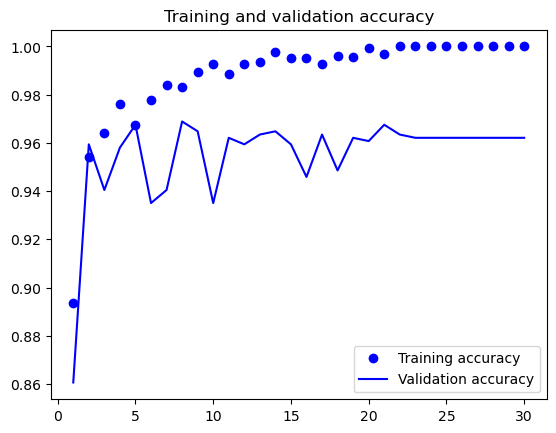

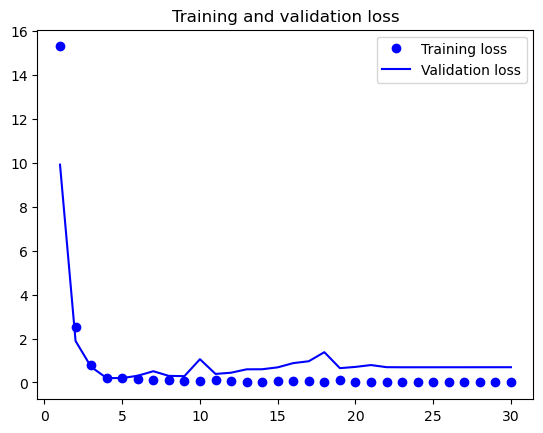

In [32]:
plot_process(history)

In [33]:
model.evaluate(test_features, test_labels)

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9741 - loss: 0.9935   


[0.8870139122009277, 0.9686146974563599]

In [34]:
best_model = load_model("feature_extraction_vgg16.keras")
best_model.evaluate(test_features, test_labels)

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9705 - loss: 0.2910


[0.24829156696796417, 0.9696969985961914]

### VGG16 with Data Augmentation:

In [36]:
conv_base_vgg = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False)
conv_base_vgg.trainable = False

<IPython.core.display.Javascript object>

In [37]:
augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
        layers.RandomBrightness(0.2)
    ]
)

inputs = keras.Input(shape=(180, 180, 3))
x = augmentation(inputs)
x = keras.applications.vgg16.preprocess_input(x)
x = conv_base_vgg(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
# x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [38]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="feature_extraction_with_augmentation.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    X_train, y_train,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks)

<IPython.core.display.Javascript object>

Epoch 1/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 298s 3s/step - accuracy: 0.7549 - loss: 58.5164 - val_accuracy: 0.7713 - val_loss: 15.5377
Epoch 2/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 288s 3s/step - accuracy: 0.8928 - loss: 5.3665 - val_accuracy: 0.9310 - val_loss: 1.0349
Epoch 3/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 292s 3s/step - accuracy: 0.9138 - loss: 0.8309 - val_accuracy: 0.9323 - val_loss: 0.2862
Epoch 4/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 283s 3s/step - accuracy: 0.9078 - loss: 0.3410 - val_accuracy: 0.9107 - val_loss: 0.3551
Epoch 5/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 285s 3s/step - accuracy: 0.9011 - loss: 0.4001 - val_accuracy: 0.9486 - val_loss: 0.1884
Epoch 6/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 284s 3s/step - accuracy: 0.9168 - loss: 0.4002 - val_accuracy: 0.9499 - val_loss: 0.1940
Epoch 7/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 287s 3s/step - accuracy: 0.9322 - loss: 0.2798 - val_accuracy: 0.9350 - val_loss: 0.3096
Epoch 8/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 307s 3s/step - accuracy: 0.9262 - loss: 0.2903 - val_accuracy: 0.9526 -

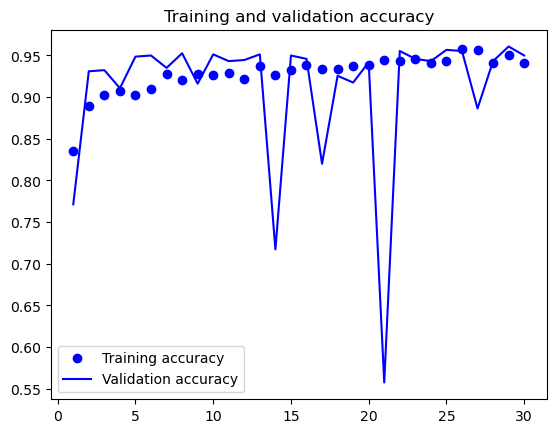

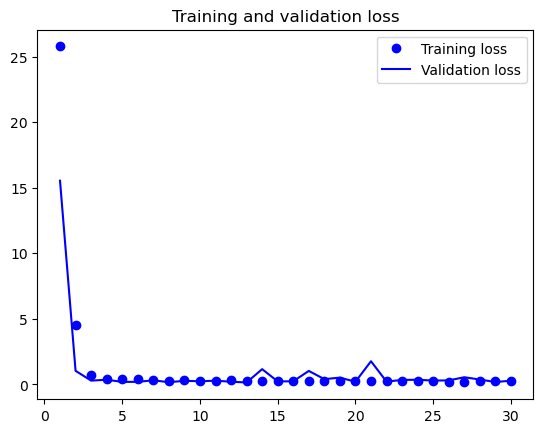

In [39]:
plot_process(history)

In [40]:
best_model = load_model("feature_extraction_with_augmentation.keras")
best_model.evaluate(X_test, y_test)

29/29 ━━━━━━━━━━━━━━━━━━━━ 83s 3s/step - accuracy: 0.9640 - loss: 0.2073


[0.1805923581123352, 0.9545454382896423]

### Fine Tuning Pretrained Model:

In [42]:
conv_base_vgg.trainable = True
for layer in conv_base_vgg.layers[:-4]:
    layer.trainable = False

In [43]:
best_model.compile(loss="binary_crossentropy",
              optimizer=keras.optimizers.RMSprop(learning_rate=1e-5),
              metrics=["accuracy"])

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="fine_tuning_vgg.keras",
        save_best_only=True,
        monitor="val_loss")
]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [44]:
history = best_model.fit(
    X_train, y_train,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 360s 4s/step - accuracy: 0.9639 - loss: 0.1225 - val_accuracy: 0.9526 - val_loss: 0.1367
Epoch 2/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 346s 4s/step - accuracy: 0.9693 - loss: 0.1035 - val_accuracy: 0.9540 - val_loss: 0.1297
Epoch 3/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 355s 4s/step - accuracy: 0.9629 - loss: 0.1242 - val_accuracy: 0.9526 - val_loss: 0.1209
Epoch 4/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 349s 4s/step - accuracy: 0.9680 - loss: 0.1009 - val_accuracy: 0.9526 - val_loss: 0.1163
Epoch 5/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 336s 4s/step - accuracy: 0.9627 - loss: 0.1135 - val_accuracy: 0.9540 - val_loss: 0.1136
Epoch 6/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 341s 4s/step - accuracy: 0.9577 - loss: 0.1053 - val_accuracy: 0.9540 - val_loss: 0.1090
Epoch 7/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 334s 4s/step - accuracy: 0.9622 - loss: 0.0948 - val_accuracy: 0.9553 - val_loss: 0.1093
Epoch 8/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 329s 4s/step - accuracy: 0.9674 - loss: 0.0931 - val_accuracy: 0.9553 - v

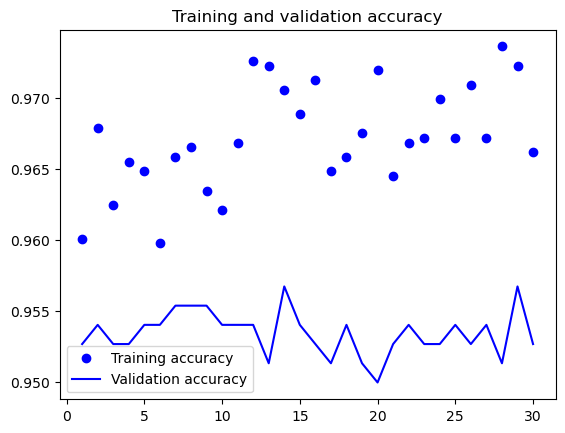

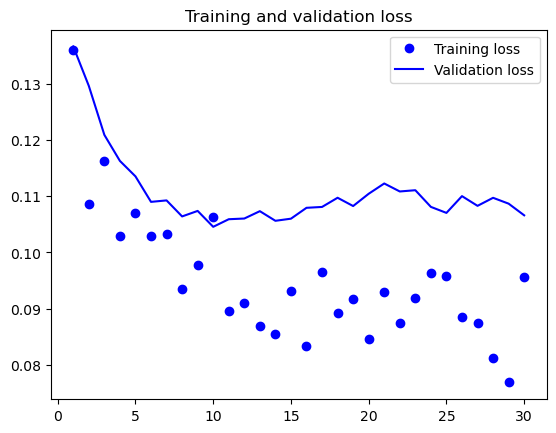

In [45]:
plot_process(history)

In [46]:
best_model.evaluate(X_test, y_test)

29/29 ━━━━━━━━━━━━━━━━━━━━ 92s 3s/step - accuracy: 0.9691 - loss: 0.1531


[0.12956830859184265, 0.959956705570221]

In [47]:
best_model = load_model("fine_tuning_vgg.keras")
best_model.evaluate(X_test, y_test)

29/29 ━━━━━━━━━━━━━━━━━━━━ 94s 3s/step - accuracy: 0.9660 - loss: 0.1514


[0.1290246993303299, 0.9577922224998474]

* Seems like there is space for improvement with more epochs

Epoch 1/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 379s 4s/step - accuracy: 0.9628 - loss: 0.0950 - val_accuracy: 0.9526 - val_loss: 0.1069
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 379s 4s/step - accuracy: 0.9671 - loss: 0.0928 - val_accuracy: 0.9513 - val_loss: 0.1096
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 382s 4s/step - accuracy: 0.9679 - loss: 0.0871 - val_accuracy: 0.9513 - val_loss: 0.1093
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 384s 4s/step - accuracy: 0.9661 - loss: 0.0952 - val_accuracy: 0.9526 - val_loss: 0.1085
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 376s 4s/step - accuracy: 0.9713 - loss: 0.0840 - val_accuracy: 0.9513 - val_loss: 0.1115
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 321s 3s/step - accuracy: 0.9618 - loss: 0.0883 - val_accuracy: 0.9526 - val_loss: 0.1094
Epoch 7/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 337s 4s/step - accuracy: 0.9679 - loss: 0.0904 - val_accuracy: 0.9526 - val_loss: 0.1062
Epoch 8/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 342s 4s/step - accuracy: 0.9630 - loss: 0.0992 - val_accuracy: 0.9526 - v

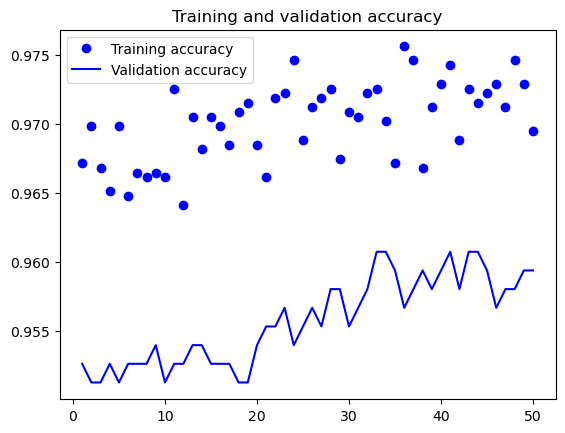

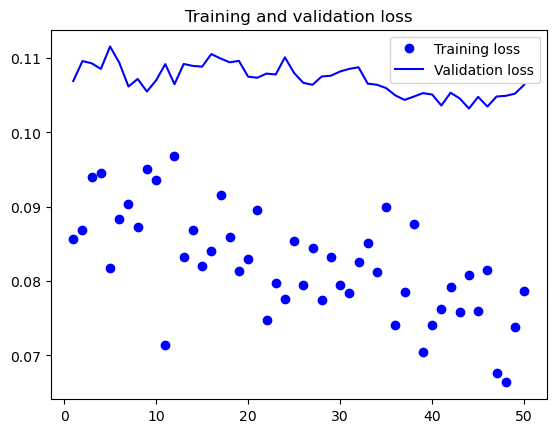

In [49]:
history = best_model.fit(
    X_train, y_train,
    epochs=50,
    validation_data=validation_dataset,
    callbacks=callbacks)
plot_process(history)

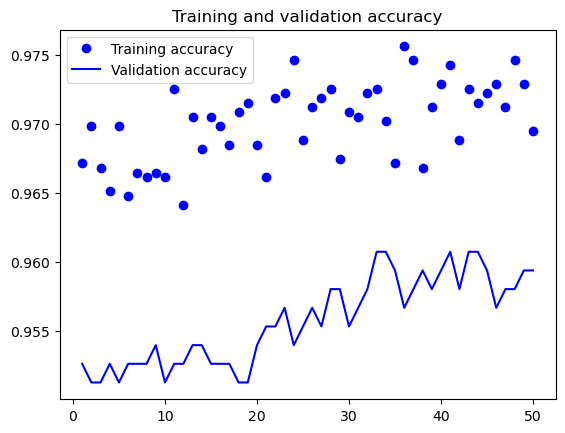

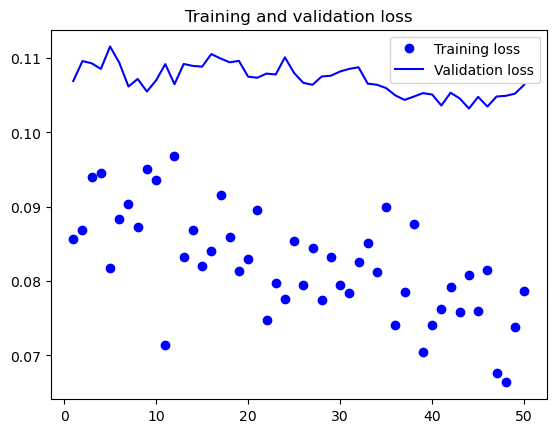

In [50]:
plot_process(history)

In [51]:
best_model.evaluate(X_test, y_test)

29/29 ━━━━━━━━━━━━━━━━━━━━ 81s 3s/step - accuracy: 0.9705 - loss: 0.1606


[0.13684968650341034, 0.959956705570221]

---

## Results analysis

In [108]:
from IPython.display import display

In [110]:
def generate_classification_reports(model_path, threshold = 0.5, pretrained=False):
    model_name = model_path[:-6]  # remove `keras` suffix
    print(f"{model_name}:\n")
    model = load_model(model_path)
    if pretrained:
        y_pred = model.predict(test_features)
    else:
        y_pred = model.predict(X_test)
        
    y_pred = (y_pred > threshold).astype(int)

    disp = ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap = 'Blues', display_labels= ['Healthy','Tumor'])
    plt.title(f"\nConfusion Matrix - {model_name}")  
    plt.gcf().set_size_inches(6, 4)
    plt.show()
    
    clf_report = classification_report(y_test, y_pred, output_dict=True, target_names = ['Healthy','Tumor'], digits = 4)

    return clf_report

In [112]:
def format_and_extract(clf):
    '''
    Defining evaluation metric as recall of true positives
    It is preffered to detect correctly as many as possible, even at the cost of a few false positives
    '''
    df = pd.DataFrame(clf).round(3)
    acc = df.iloc[1,2]
    df = df.drop(columns = ['accuracy'])
    score = df.loc["recall","Tumor"]
    return df, acc, score

In [114]:
models = ['from_scratch.keras',
          'from_scratch_with_augmentation.keras', 
          'feature_extraction_vgg16.keras',
          'feature_extraction_with_augmentation.keras',
          'fine_tuning_vgg.keras']

from_scratch:

29/29 ━━━━━━━━━━━━━━━━━━━━ 4s 145ms/step


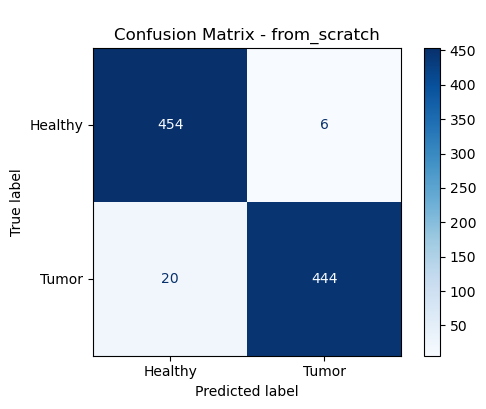

<IPython.core.display.Javascript object>

,Healthy,Tumor,macro avg,weighted avg
precision,0.958,0.987,0.972,0.972
recall,0.987,0.957,0.972,0.972
f1-score,0.972,0.972,0.972,0.972
support,460.000,464.000,924.000,924.000




from_scratch_with_augmentation:

29/29 ━━━━━━━━━━━━━━━━━━━━ 5s 153ms/step


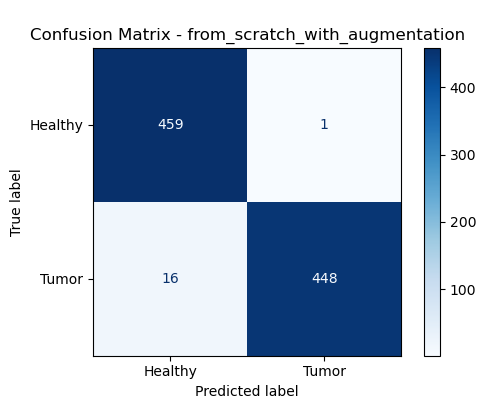

<IPython.core.display.Javascript object>

,Healthy,Tumor,macro avg,weighted avg
precision,0.966,0.998,0.982,0.982
recall,0.998,0.966,0.982,0.982
f1-score,0.982,0.981,0.982,0.982
support,460.000,464.000,924.000,924.000




feature_extraction_vgg16:

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


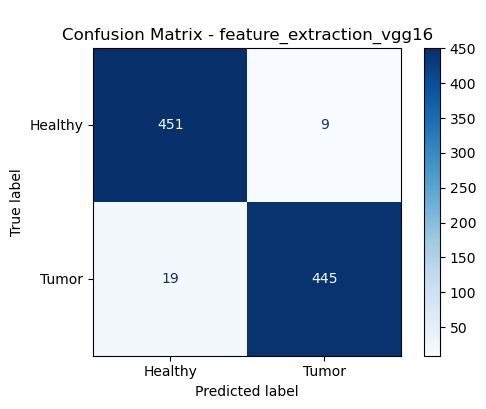

<IPython.core.display.Javascript object>

,Healthy,Tumor,macro avg,weighted avg
precision,0.96,0.980,0.97,0.97
recall,0.98,0.959,0.97,0.97
f1-score,0.97,0.969,0.97,0.97
support,460.00,464.000,924.00,924.00




feature_extraction_with_augmentation:

29/29 ━━━━━━━━━━━━━━━━━━━━ 83s 3s/step


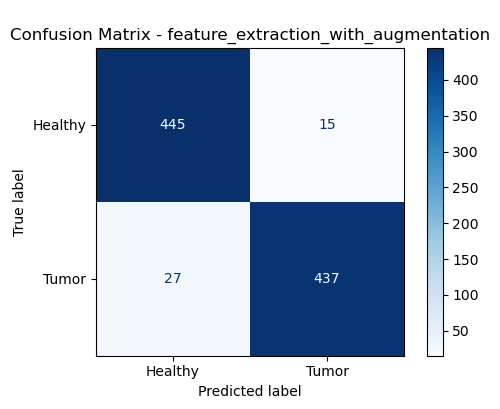

<IPython.core.display.Javascript object>

,Healthy,Tumor,macro avg,weighted avg
precision,0.943,0.967,0.955,0.955
recall,0.967,0.942,0.955,0.955
f1-score,0.955,0.954,0.955,0.955
support,460.000,464.000,924.000,924.000




fine_tuning_vgg:

29/29 ━━━━━━━━━━━━━━━━━━━━ 124s 4s/step


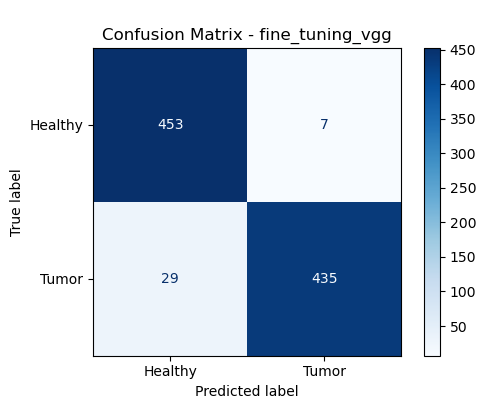

<IPython.core.display.Javascript object>

,Healthy,Tumor,macro avg,weighted avg
precision,0.940,0.984,0.962,0.962
recall,0.985,0.938,0.961,0.961
f1-score,0.962,0.960,0.961,0.961
support,460.000,464.000,924.000,924.000


In [116]:
scores = {}
acc_scores = {}
for m in models:
    pretrained = (m=='feature_extraction_vgg16.keras') or (m=='feature_extraction_vgg16_mri.keras')
    clf_report = generate_classification_reports(m, 0.5 ,pretrained = pretrained)
    df, acc, score = format_and_extract(clf_report)
    m = m[:-6]
    scores[m] = score
    acc_scores[m] = acc
    display(df)
    print("==============================================================================\n\n")


In [167]:
acc_df = pd.DataFrame(acc_scores, index = ['Accuracy']).T.sort_values('Accuracy', ascending = False)
positive_recall_df = pd.DataFrame(scores, index = ['Positive recall']).T.sort_values('Positive recall', ascending = False)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [169]:
display(acc_df)
display(positive_recall_df)

,Accuracy
from_scratch_with_augmentation,0.982
from_scratch,0.972
feature_extraction_vgg16,0.970
fine_tuning_vgg,0.961
feature_extraction_with_augmentation,0.955


,Positive recall
from_scratch_with_augmentation,0.966
feature_extraction_vgg16,0.959
from_scratch,0.957
feature_extraction_with_augmentation,0.942
fine_tuning_vgg,0.938
